# Embed RUL

This Jupyter notebook provides a full example of the Embed RUL Approach.

## Imports and setup:

The following code cell deals with all the imports and initial setup. The log level of tensorflow is reduced to have less GPU info messages. The seed of the numpy random number generator is fixed to create reproducible results and the ray-tune framework is initialized.

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'

In [2]:
from multiprocessing import cpu_count

import jsonpickle as jp
import numpy as np
import ray
from ray import tune
from ray.tune.integration.keras import TuneReportCallback
from ray.tune.schedulers import HyperBandForBOHB
from ray.tune.suggest.bohb import TuneBOHB
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler

from ml4pdm.data import NUMERIC, TIMESERIES
from ml4pdm.evaluation.metrics import loss_asymmetric, score_performance, loss_false_positive_rate, loss_false_negative_rate
from ml4pdm.parsing import DatasetParser, PipelineConfigParser
from ml4pdm.prediction import EmbedRUL
from ml4pdm.transformation import AttributeFilter, RNNAutoencoder, WindowingApproach, SklearnWrapper

np.random.seed(2)
ray.init(include_dashboard=False, ignore_reinit_error=True)

{'node_ip_address': '192.168.31.31',
 'raylet_ip_address': '192.168.31.31',
 'redis_address': '192.168.31.31:6379',
 'object_store_address': 'tcp://127.0.0.1:61321',
 'raylet_socket_name': 'tcp://127.0.0.1:58630',
 'webui_url': None,
 'session_dir': 'C:\\Users\\CHRIST~1\\AppData\\Local\\Temp\\ray\\session_2021-08-25_12-39-01_378039_23648',
 'metrics_export_port': 64718,
 'node_id': 'df2ba74b298fdccda9f818b3a5694c5a1ddd6f712fb964eb6b9e57af'}

## Prepare dataset

The base for the datasets is the CMAPSS FD001. The train and test datasets are prepared by removing non-changing as well as settings features. After that a min max scaling is also applied per feature. Windowing is applied to have fixed size arrays to pass to the RNN Autoencoder.

In [3]:
train_dataset, test_dataset = DatasetParser.get_cmapss_data(test=True)
train_dataset = AttributeFilter.remove_features(train_dataset, [1, 2, 3, 4, 8, 13, 19, 22])
test_dataset = AttributeFilter.remove_features(test_dataset, [1, 2, 3, 4, 8, 13, 19, 22])

preprocessing = make_pipeline(SklearnWrapper(MinMaxScaler(), SklearnWrapper.extract_timeseries_concatenated, SklearnWrapper.rebuild_timeseries_concatenated),
                              "passthrough")

train_dataset = preprocessing.fit_transform(train_dataset)
test_dataset = preprocessing.transform(test_dataset)

## RNN Encoder-Decoder

The RNN Autoencoder is an integral part of the Embed RUL approach as it produces the embeddings that will be used to build hi curves and predict the RUL based on them.

### Hyperparameter optimization

The next code cell performs hyperparameter optimization on the RNN ED. The goal is to find parameters for which the timeseries reconstructed from the embeddings matches the original timeseries best.

In [ ]:
def rnn_ed_training(config, data=None):
    rnn_ed_candidate = make_pipeline(WindowingApproach(30), RNNAutoencoder(num_features=16, epochs=50, window_size=30, batch_size=64, verbose=2, plot=False,
                                     units=config["units"], dropout=config["dropout"], learning_rate=config["learning_rate"]), "passthrough")
    rnn_ed_candidate.fit(data, callbacks=[TuneReportCallback(["loss", "val_loss"])])

algo = TuneBOHB(seed=2)
bohb = HyperBandForBOHB(time_attr="training_iteration", max_t=50)

analysis = tune.run(
    tune.with_parameters(rnn_ed_training, data=train_dataset),
    search_alg=algo,
    scheduler=bohb,
    metric="val_loss",
    mode="min",
    num_samples=-1,
    time_budget_s=int(6*60*60),
    resources_per_trial={"cpu": cpu_count(), "gpu": 1},
    config={
        "dropout": tune.uniform(0, 0.8),
        "learning_rate": tune.loguniform(1e-7, 1e-2),
        "units": tune.choice(range(1, 400+1, 1)),
    }
)

best_config = analysis.get_best_config(metric="val_loss", mode="min")
print("Best config: ", best_config)

### Training best config and saving

The RNN ED trained with best config found in hyperparameter optimization is saved in a JSON file.

Epoch 1/50
222/222 [==============================] - 3s 14ms/step - loss: 0.0139 - mae: 0.0682 - val_loss: 0.0054 - val_mae: 0.0517
Epoch 2/50
222/222 [==============================] - 2s 11ms/step - loss: 0.0058 - mae: 0.0526 - val_loss: 0.0053 - val_mae: 0.0511
Epoch 3/50
222/222 [==============================] - 2s 11ms/step - loss: 0.0057 - mae: 0.0522 - val_loss: 0.0053 - val_mae: 0.0509
Epoch 4/50
222/222 [==============================] - 2s 10ms/step - loss: 0.0057 - mae: 0.0521 - val_loss: 0.0053 - val_mae: 0.0515
Epoch 5/50
222/222 [==============================] - 2s 10ms/step - loss: 0.0056 - mae: 0.0517 - val_loss: 0.0052 - val_mae: 0.0505
Epoch 6/50
222/222 [==============================] - 2s 10ms/step - loss: 0.0056 - mae: 0.0517 - val_loss: 0.0053 - val_mae: 0.0512
Epoch 7/50
222/222 [==============================] - 2s 10ms/step - loss: 0.0056 - mae: 0.0514 - val_loss: 0.0052 - val_mae: 0.0502
Epoch 8/50
222/222 [==============================] - 2s 10ms/step - 

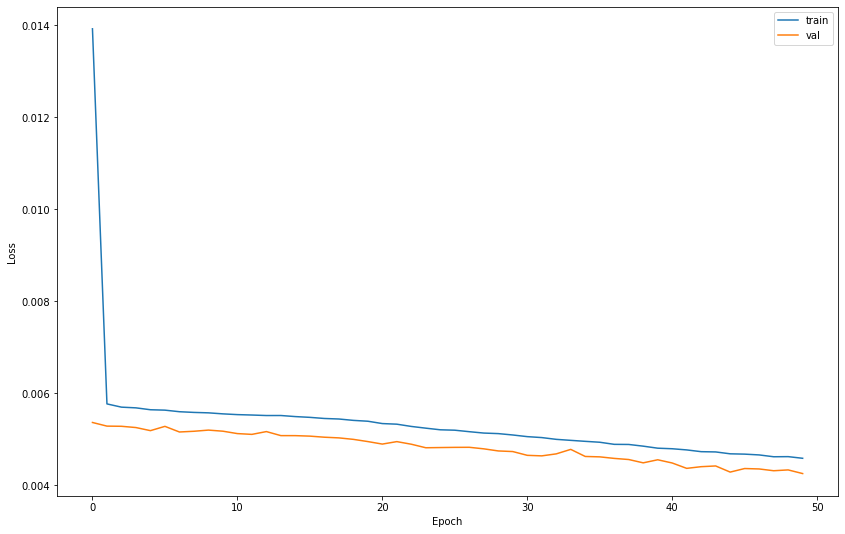

In [4]:
best_config = {'dropout': 0.03263098518086382, 'learning_rate': 0.005840766783749317, 'units': 270}

rnn_ed = RNNAutoencoder(num_features=16, epochs=50, window_size=30, batch_size=64, verbose=1, plot=True, **best_config)
pipeline = make_pipeline(WindowingApproach(30), rnn_ed)
pipeline.fit(train_dataset)

with open("./examples/embed_rul/embed_rul_rnn_ed.json", "w") as f:
    f.write(jp.dumps(rnn_ed))


### Evaluation

The RNN ED can be evaluated visually by plotting the original timeseries and the timeseries reconstructed from the embeddings.

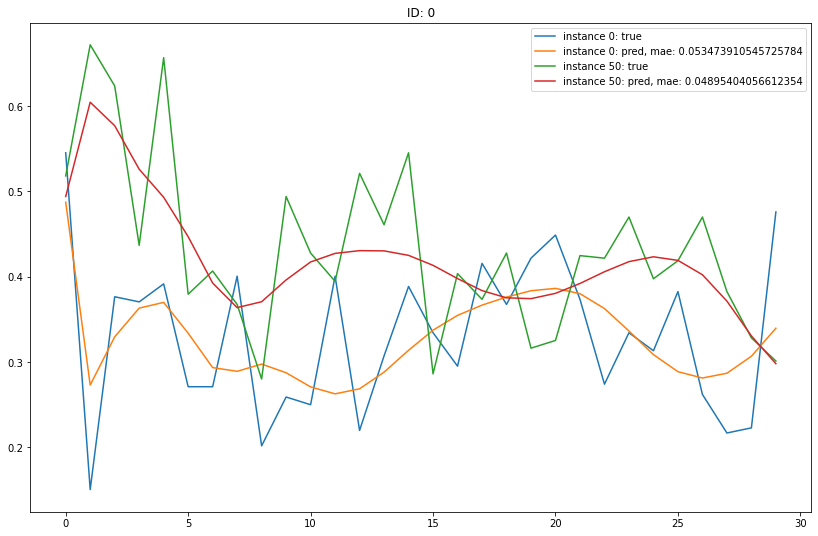

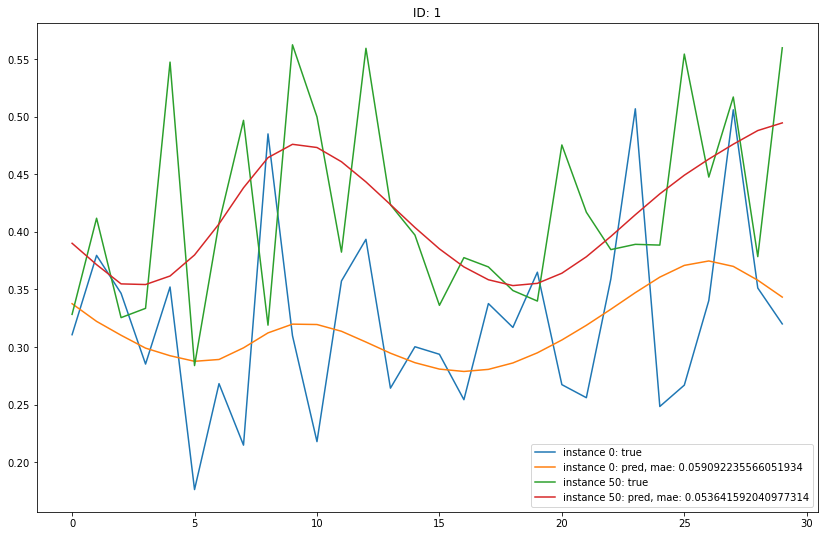

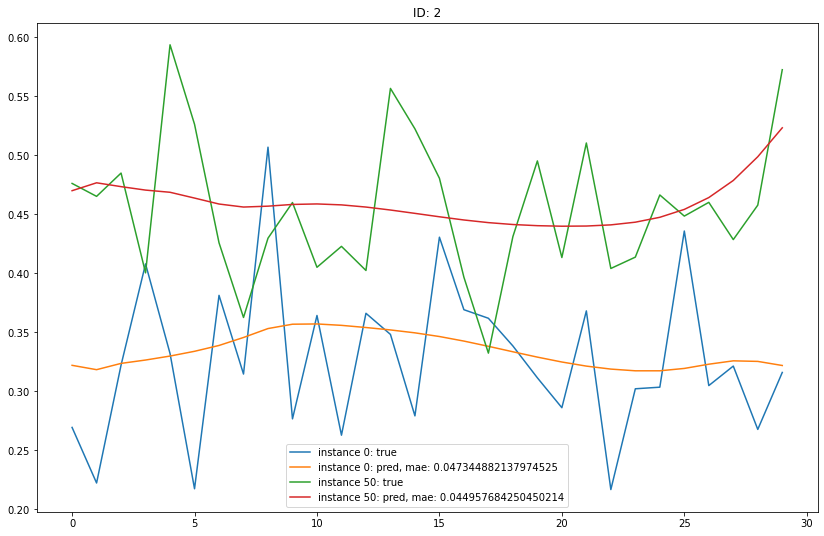

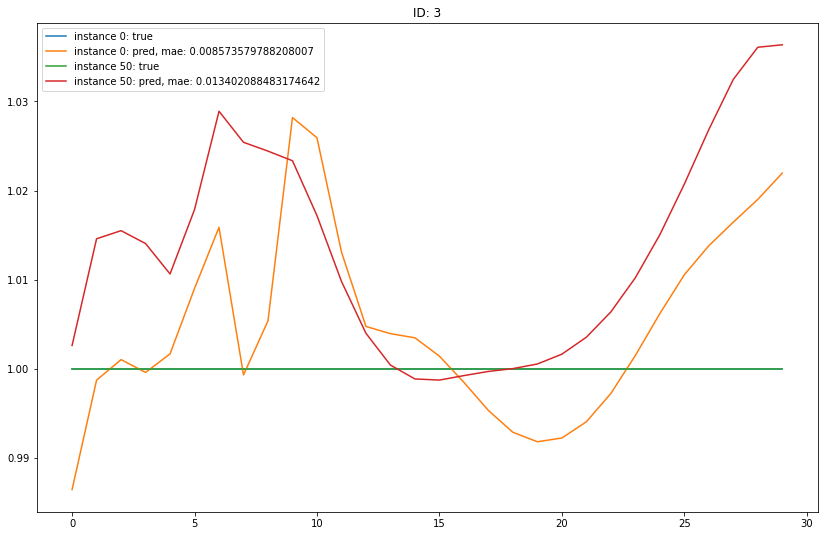

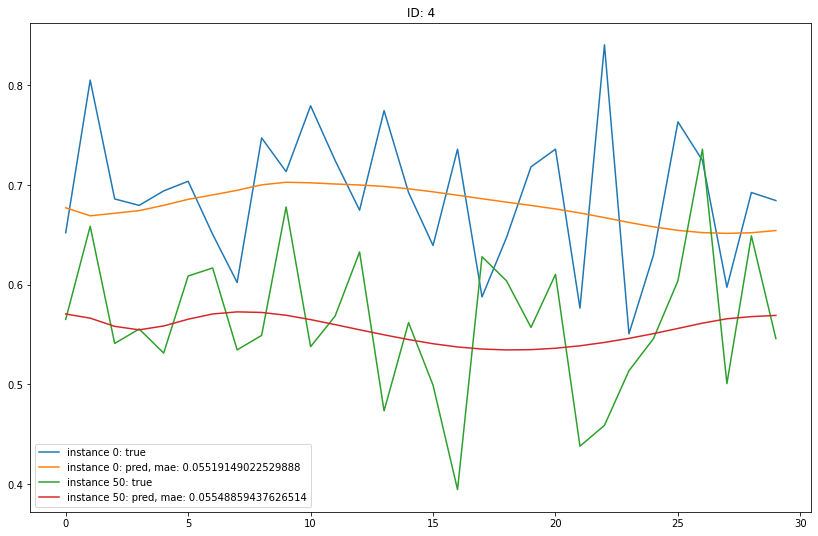

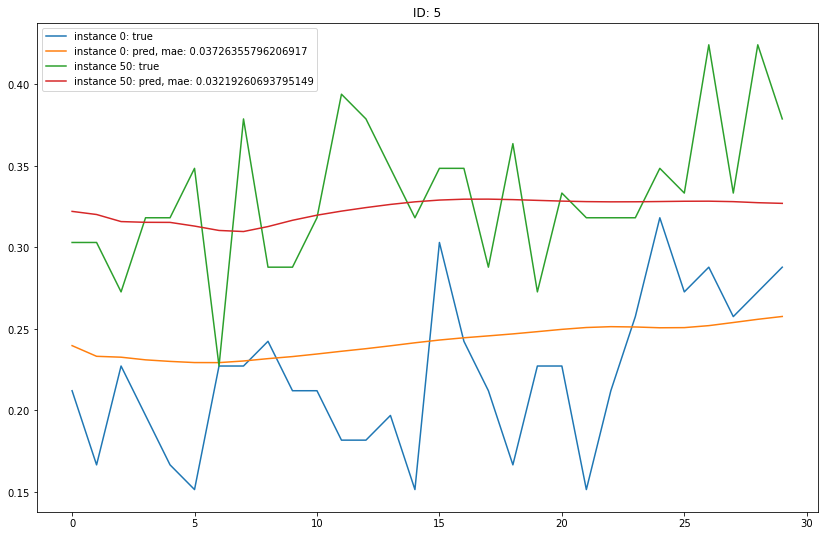

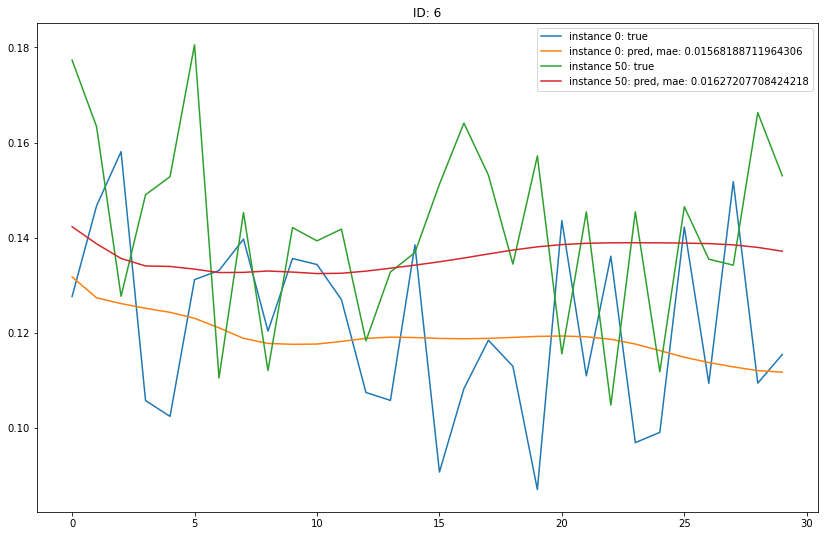

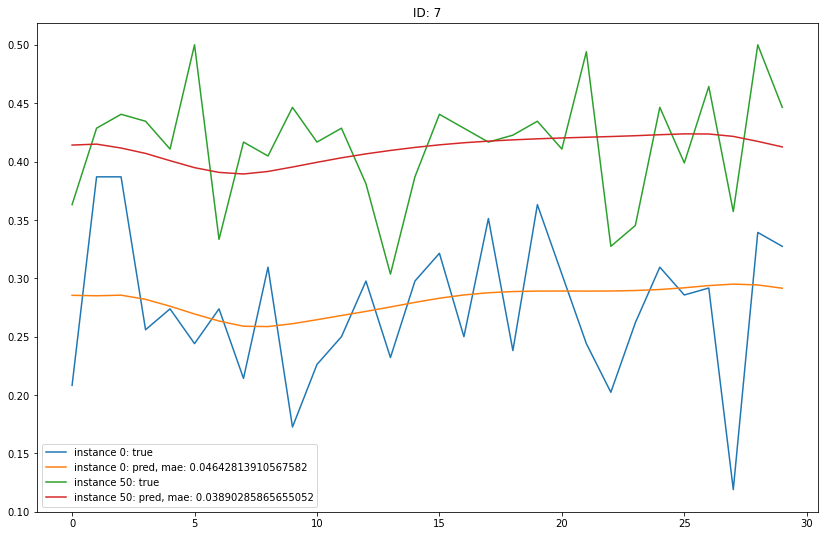

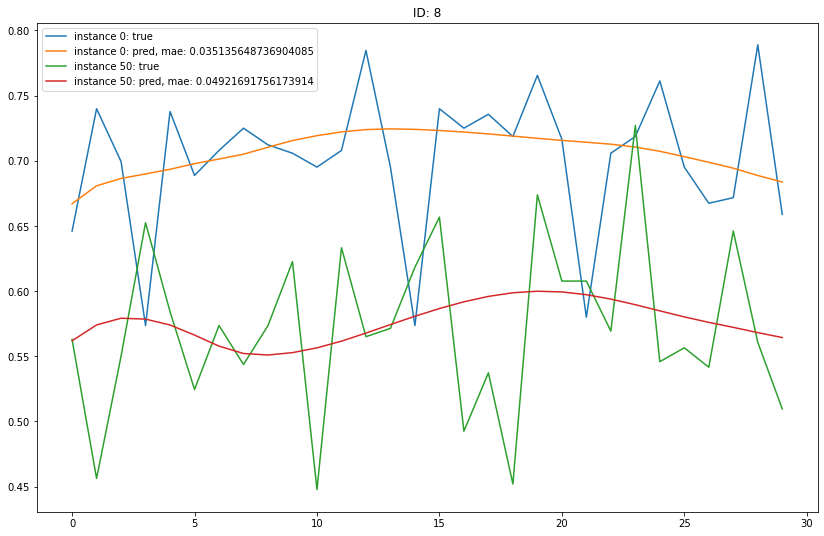

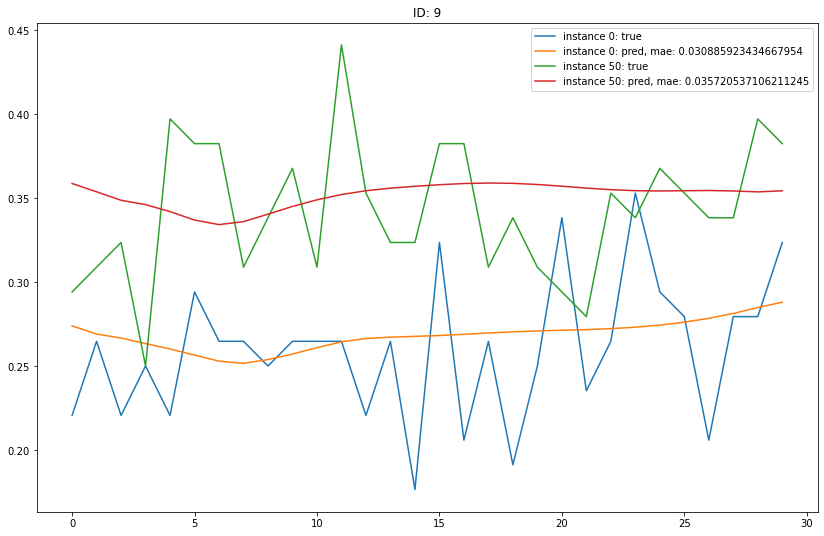

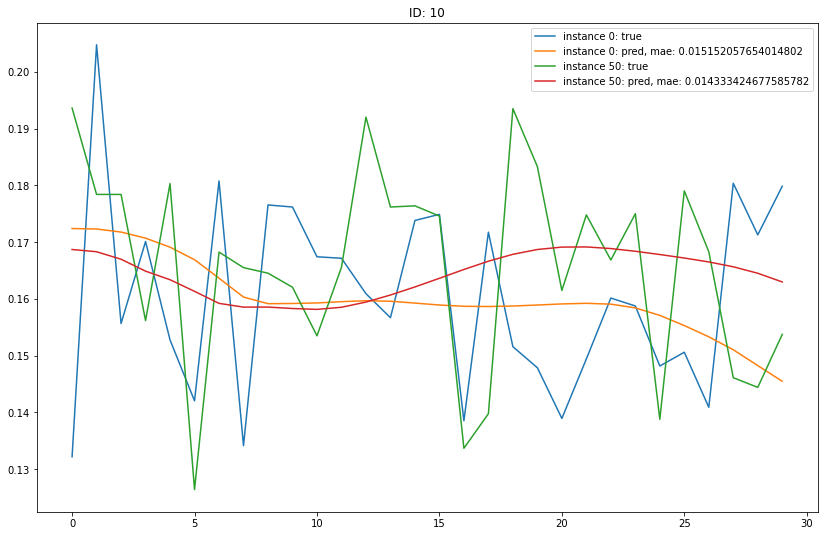

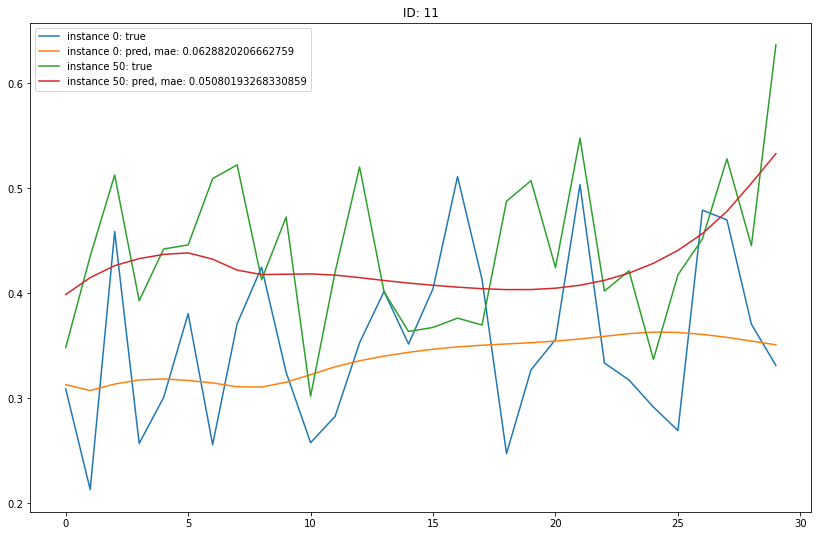

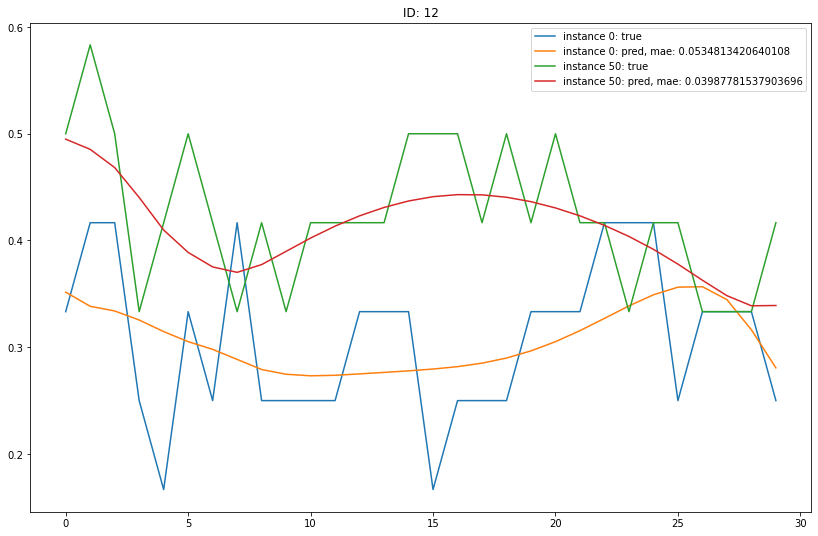

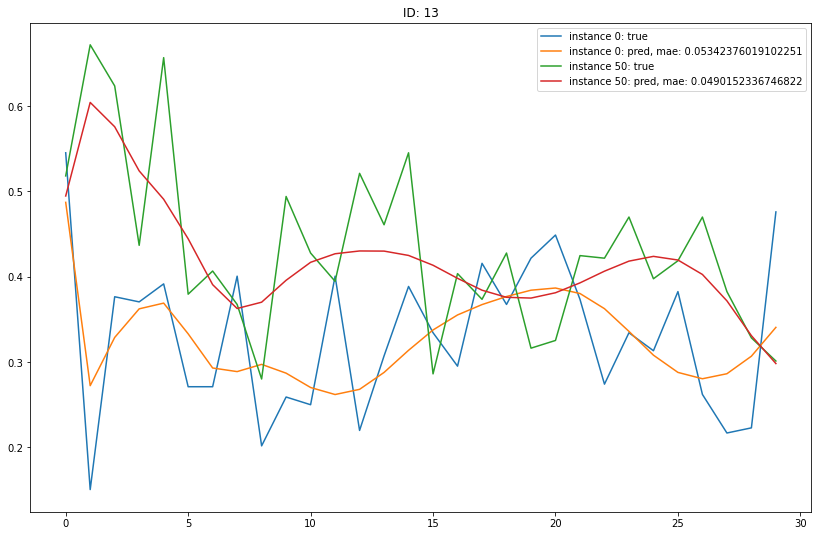

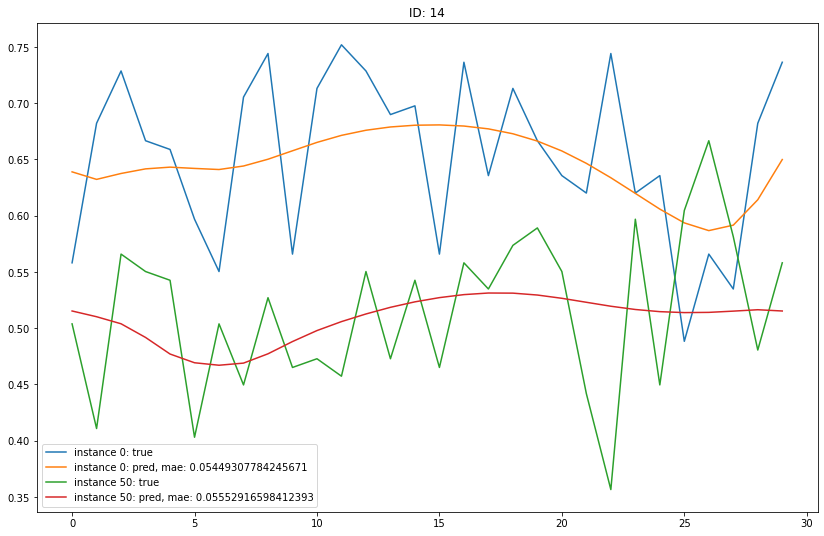

mae: 0.0476650115898808


In [5]:
with open("./examples/embed_rul/embed_rul_rnn_ed.json", "r") as f:
    rnn_ed = jp.loads(f.read())

_, true = WindowingApproach(30).transform(test_dataset).get_multivariate_of_type(TIMESERIES(NUMERIC(), NUMERIC()))
true = np.array(true, copy=False)
true = np.reshape(true, (true.shape[0], true.shape[1]*true.shape[2]))

pipeline = make_pipeline(WindowingApproach(30), rnn_ed)
predicted = pipeline.predict(test_dataset)
_, predicted = predicted.get_multivariate_of_type(TIMESERIES(NUMERIC(), NUMERIC()))
predicted = np.array(predicted, copy=False)
predicted = np.reshape(predicted, (predicted.shape[0], predicted.shape[1]*predicted.shape[2]))

print("mae:", mean_absolute_error(true, predicted))
rnn_ed.plot = False
rnn_ed.verbose = 0

## Complete Pipeline
### Hyperparameter optimization

This hyperparameter optimization uses the pretrained RNN ED and searches optimal parameters for the final RUL prediction step.

In [ ]:
def pipeline_training(config, data=None):
    temp_pipeline = EmbedRUL.from_params_pretrained_rnn(data["rnn_ed"], lambda_param=config["lambda_param"], max_time_lag=config["max_time_lag"], 
                                                        alpha=config["alpha"], max_rul=config["max_rul"])
    temp_pipeline.fit(data["train_dataset"])
    tune.report(loss=mean_squared_error(data["test_dataset"].target, temp_pipeline.predict(data["test_dataset"])))

data_dict = {
    "rnn_ed": rnn_ed,
    "train_dataset": train_dataset,
    "test_dataset": test_dataset,
}

algo = TuneBOHB(seed=2)

analysis = tune.run(
    tune.with_parameters(pipeline_training, data=data_dict),
    search_alg=algo,
    metric="loss",
    mode="min",
    num_samples=-1,
    time_budget_s=int(6*60*60),
    resources_per_trial={"cpu": cpu_count(), "gpu": 1},
    config={
        "lambda_param": tune.uniform(1e-6, 50),
        "alpha": tune.uniform(0.01, 0.99),
        "max_rul": tune.choice(range(60, 200+1, 1)),
        "max_time_lag": tune.choice(range(1, 100+1, 1))
    }
)

best_config = analysis.get_best_config(metric="loss", mode="min")
print("Best config: ", best_config)

### Training best config and saving

The complete Embed RUL approach is trained with the best config found in hyperparameter optimization and is saved in a JSON file.

In [6]:
best_config = {'lambda_param': 21.83736371459269, 'alpha': 0.42899504403018784, 'max_rul': 120, 'max_time_lag': 10}

pipeline = EmbedRUL.from_params_pretrained_rnn(rnn_ed, **best_config)
pipeline.fit(train_dataset)

PipelineConfigParser.save_to_file(pipeline, "./examples/embed_rul/embed_rul_pipeline.json")

### Evaluation

The best config that was obtained in the above hyperparameter optimization is evaluated using various metrics. This allows for comparing it with other approaches.

In [7]:
pipeline = PipelineConfigParser.parse_from_file("./examples/embed_rul/embed_rul_pipeline.json")
pr_rul = pipeline.predict(test_dataset)

print("Scores from training:")
print("S:", loss_asymmetric(test_dataset.target, pr_rul))
print("MSE:", mean_squared_error(test_dataset.target, pr_rul))
print("A(%):", 100*score_performance(test_dataset.target, pr_rul))
print("MAE:", mean_absolute_error(test_dataset.target, pr_rul))
print("MAPE:", 100*mean_absolute_percentage_error(test_dataset.target, pr_rul))
print("FPR(%):", 100*loss_false_positive_rate(test_dataset.target, pr_rul))
print("FNR(%):", 100*loss_false_negative_rate(test_dataset.target, pr_rul))
 
print("\nScores from paper:")
print("S: 810")
print("MSE: 456")
print("A(%): 48")
print("MAE: 17")
print("MAPE: 39")
print("FPR(%): 23")
print("FNR(%): 29")

Scores from training:
S: 4700.592935461047
MSE: 1062.8554866078143
A(%): 26.0
MAE: 26.4027171425526
MAPE: 82.18152589992816
FPR(%): 30.0
FNR(%): 44.0

Scores from paper:
S: 810
MSE: 456
A(%): 48
MAE: 17
MAPE: 39
FPR(%): 23
FNR(%): 29
